In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)


2.15.0


Data Path

In [2]:
def load_test_data(file_path:str):
    '''load the .npy test data'''
    filename = file_path.split('\\')[-1]
    arr = np.load(file_path)
    H, W = arr.shape[-2], arr.shape[-1]
    arr = np.reshape(arr, (-1, H, W))
    return filename, arr
        
def normalize(arr):
    arr = np.squeeze(arr)
    datamean = np.mean(arr)
    datastd = np.std(arr)
    # print(f"MEAN:{datamean}, STD: {datastd}")
    return (arr - datamean) / datastd

def arr_recover(arr):
    arr = np.reshape(arr, (235,-1,128,96))
    nr, nc, h, w = arr.shape
    arr = arr.swapaxes(1,2)
    arr = np.reshape(arr, (nr*h, nc*w))
    return arr

In [3]:
file_paths = glob(os.path.join('test_data/*.npy'))
dataname, test_data = load_test_data(file_paths[0])
test_data = normalize(test_data)
# dataname, test_data.shape # DAS-N2N accepts input shape of (128,96)

Load Model

In [4]:
model_path = r"weights/dasn2n_model"
tuned_model_path = r"weights/TunedModel.h5"
model = tf.keras.models.load_model(model_path)
tuned_model = tf.keras.models.load_model(tuned_model_path)

Plot Model Architecture

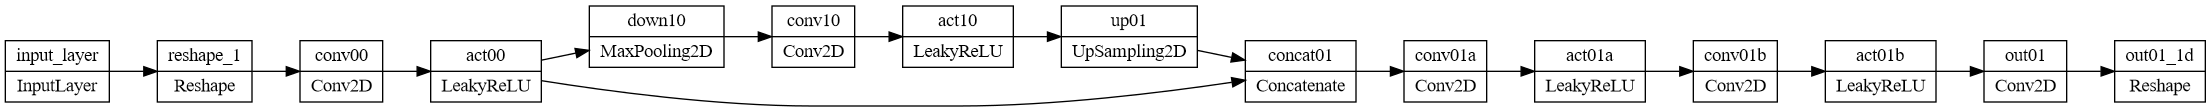

In [5]:
plot_model(model, to_file='model_arch.png', rankdir='LR')

Denoising Gaussian Noise

In [6]:
# gen random test samples to show the basic denoising ability
testnormal = np.random.normal(scale=2,size=(128,96))
testinput = np.zeros((128,96))
testinput[:,20:30] = 1
testinput[:,70:90] = -1
noised_test_input = testinput+testnormal

In [7]:
# predict (denoise)
pred = model.predict(np.expand_dims(testinput+testnormal,0))
g_pred = model.predict(np.expand_dims(testnormal,0))

1/1 [==============================] - 0s 18ms/step


<Figure size 640x480 with 0 Axes>

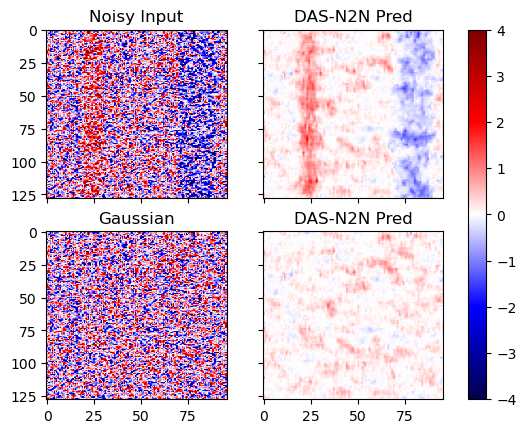

In [8]:
plt.clf()
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True)
ax[0,0].set_title("Noisy Input")
ax[0,1].set_title("DAS-N2N Pred")
ax[0,0].imshow(testinput+testnormal, cmap='seismic', aspect='auto', vmin=-4, vmax=4)
ax[0,1].imshow(np.squeeze(pred), cmap='seismic', aspect='auto', vmin=-4, vmax=4)

ax[1,0].set_title("Gaussian")
ax[1,1].set_title("DAS-N2N Pred")
ax[1,0].imshow(testnormal, cmap='seismic', aspect='auto', vmin=-4, vmax=4)
im = ax[1,1].imshow(np.squeeze(g_pred), cmap='seismic', aspect='auto', vmin=-4, vmax=4)

fig.colorbar(im, ax=ax.ravel().tolist())

In [9]:
# Define zoom region
# x1, x2, y1, y2
region = [300, 556, 500, 1012]

In [10]:
def plot_zoomed_fig(arr,x1,x2,y1,y2):
    fig, ax = plt.subplots(figsize=(6,6))

    # Define the extent to fit your array
    extent = (0, arr.shape[1], 0, arr.shape[0])

    # Display the image
    ax.imshow(arr, extent=extent, origin='lower', cmap='seismic', vmin=-1, vmax=1, aspect='auto')

    # Create inset axis
    axins = ax.inset_axes(
        [0.5, 0.5, 0.47, 0.47],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(arr, extent=extent, origin='lower', cmap='seismic', vmin=-1, vmax=1, aspect='auto')
    ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=2.)
    plt.show()

In [16]:
test_data.shape

(2585, 128, 96)

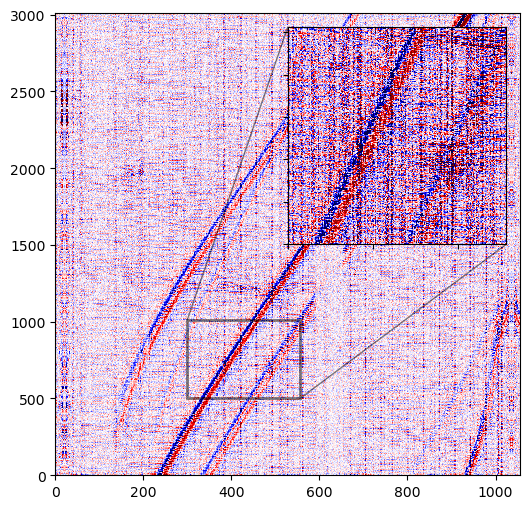

In [11]:
plot_raw = arr_recover(test_data)[::10,:]  # downsample for plotting
plot_zoomed_fig(plot_raw, *region)

Model Prediciton (Not Tuned)

In [12]:
pred = model.predict(test_data)

81/81 [==============================] - 6s 68ms/step


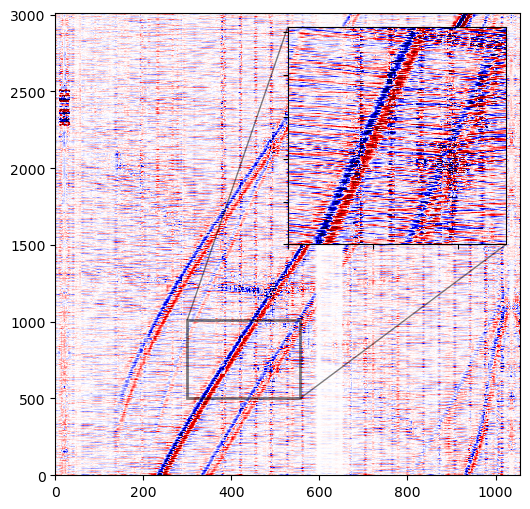

In [13]:
plot_arr = arr_recover(pred)[::10,:] # downsample for plotting
plot_zoomed_fig(plot_arr, *region)

Model Prediction (Tuned)

In [14]:
tuned_pred = tuned_model.predict(test_data)

81/81 [==============================] - 6s 68ms/step


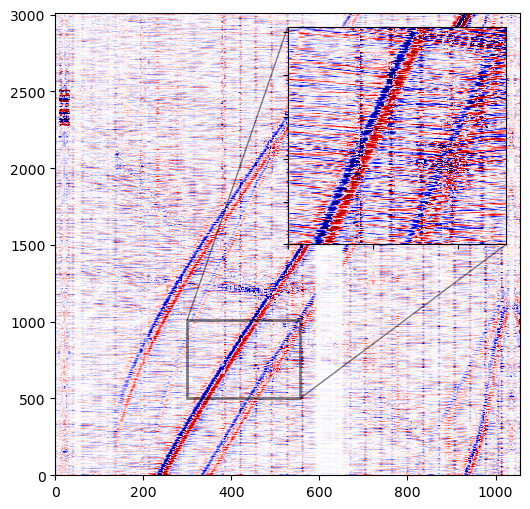

In [15]:
plot_tuned = arr_recover(tuned_pred)[::10,:] # downsample for plotting (3008)
plot_zoomed_fig(plot_tuned, *region)